## Vient du github TimeSeries Notebooks collections

In [1]:
import itertools
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from pylab import rcParams
#from ljungbox import * voir à quoi sert celui là, je le vire pour l'instant
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 10
warnings.filterwarnings('ignore')

In [3]:
file_path = 'airline.csv'

In [4]:
df = pd.read_csv('../data/consumption.csv', delimiter=';')
df.columns = ['date', 'Data'] # Rename the columns
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")

df.head(3)



,date,Data
0,2021-01-01,1516211
1,2021-01-02,1624051
2,2021-01-03,1604040


In [5]:
df.set_index(pd.to_datetime(df.date, format="%Y-%m-%D"), drop=True, inplace=True)
df.drop('date', axis=1, inplace=True)

In [6]:
df.head()

,Data
date,
2021-01-01,1516211
2021-01-02,1624051
2021-01-03,1604040
2021-01-04,1814433
2021-01-05,1871208


In [7]:
df.shape

(1126, 1)

In [8]:
count_nan = len(df) - df.count()
count_nan

Data    0
dtype: int64

In [9]:
df_germany = df.sort_index()

In [10]:
df_germany.describe()

,Data
count,1.126000e+03
mean,1.245945e+06
std,2.527454e+05
min,8.598800e+05
25%,1.061950e+06
50%,1.158098e+06
75%,1.425052e+06
max,1.923373e+06


In [11]:
df_germany.tail(10)

,Data
date,
2024-01-22,1621271
2024-01-23,1548858
2024-01-24,1440256
2024-01-25,1415383
2024-01-26,1405525
2024-01-27,1366601
2024-01-28,1362569
2024-01-29,1451603
2024-01-30,1441343


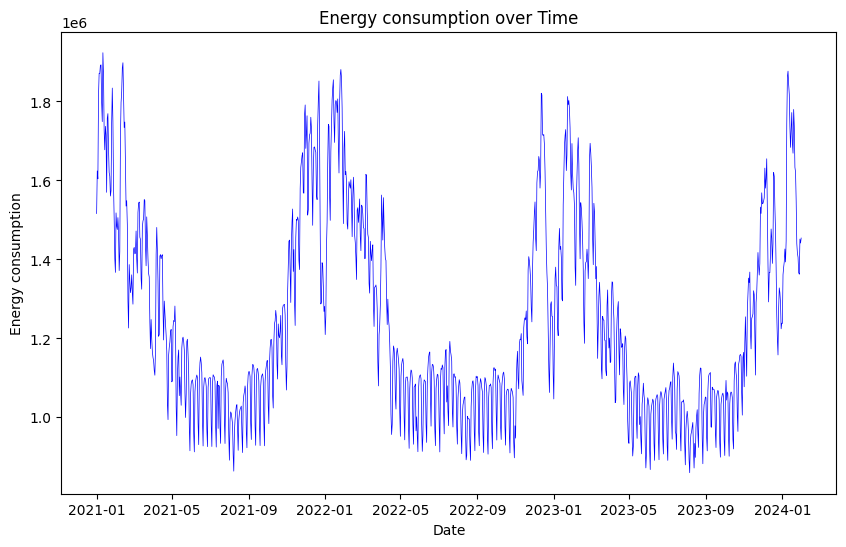

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6),dpi=100)

plt.plot(df_germany.index, df_germany.Data, linestyle='-', color='b', linewidth=0.5)

# Ajouter des étiquettes et un titre
plt.title('Energy consumption over Time')
plt.xlabel('Date')
plt.ylabel('Energy consumption')

plt.show()

In [ ]:
def stationarity_check(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=50).mean()
    movingSTD = timeseries.rolling(window=50).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(10,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    elecom_test = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(elecom_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in elecom_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)



For a Time series to be stationary, the ADCF test should have:

    p-value should be low (according to the null hypothesis)
    The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics From the above ADCF test result, we can see that p-value(near to 0.18) is very large. Also critical values lower than Test Statistics. Hence, we can safely say that our Time Series at the moment is NOT STATIONARY



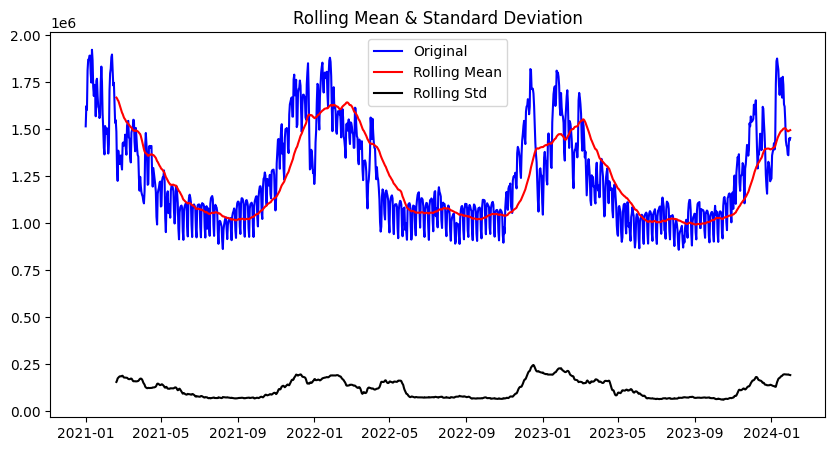

Results of Dickey Fuller Test:
Test Statistic                   -2.765911
p-value                           0.063311
#Lags Used                       22.000000
Number of Observations Used    1103.000000
Critical Value (1%)              -3.436293
Critical Value (5%)              -2.864164
Critical Value (10%)             -2.568167
dtype: float64


In [ ]:
stationarity_check(df_germany.Data)

Que conclure sur la stationarité? Il faudrait une p-value faible, et apparemment des critical value proches du Test Statistic. Ici je sais pas vraiment ce qu'on peut qualifier de proche, voir l'exemple https://www.kaggle.com/code/sunaysawant/power-consumption-time-series-arima

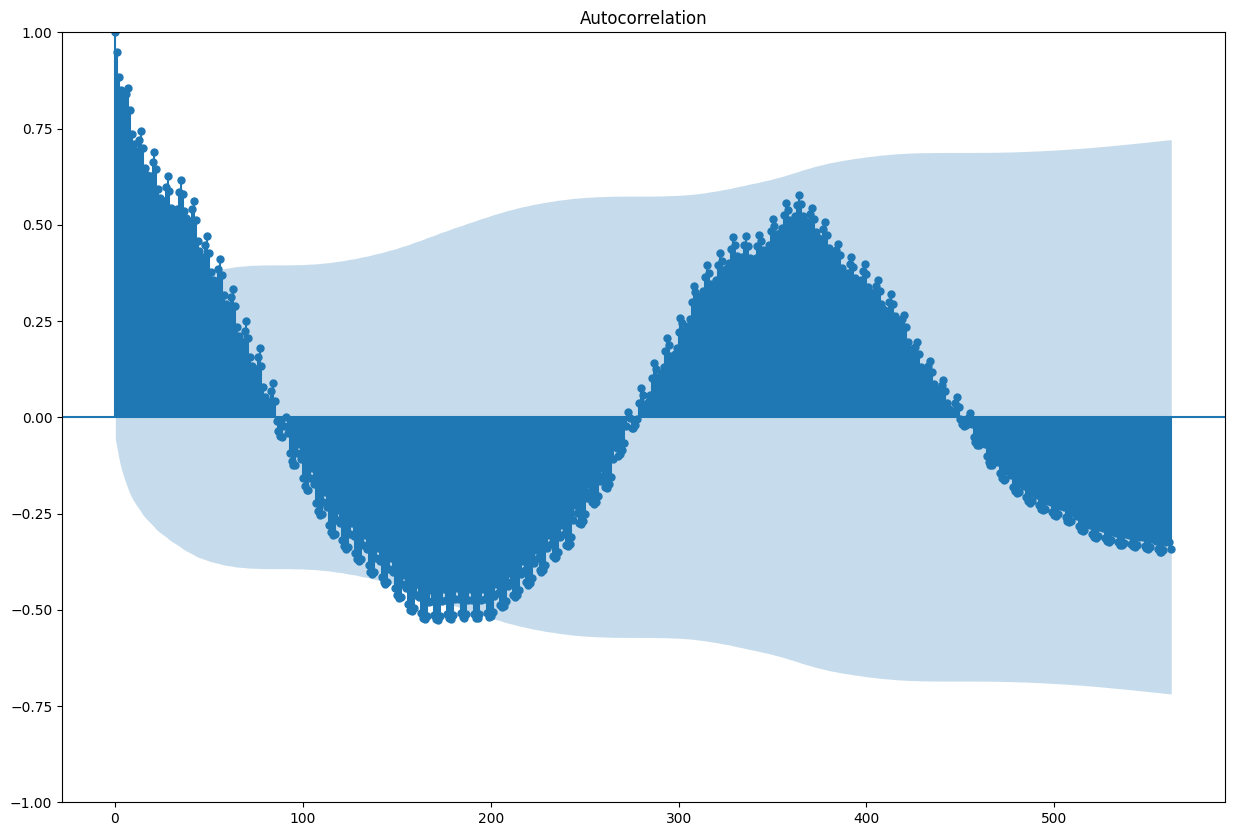

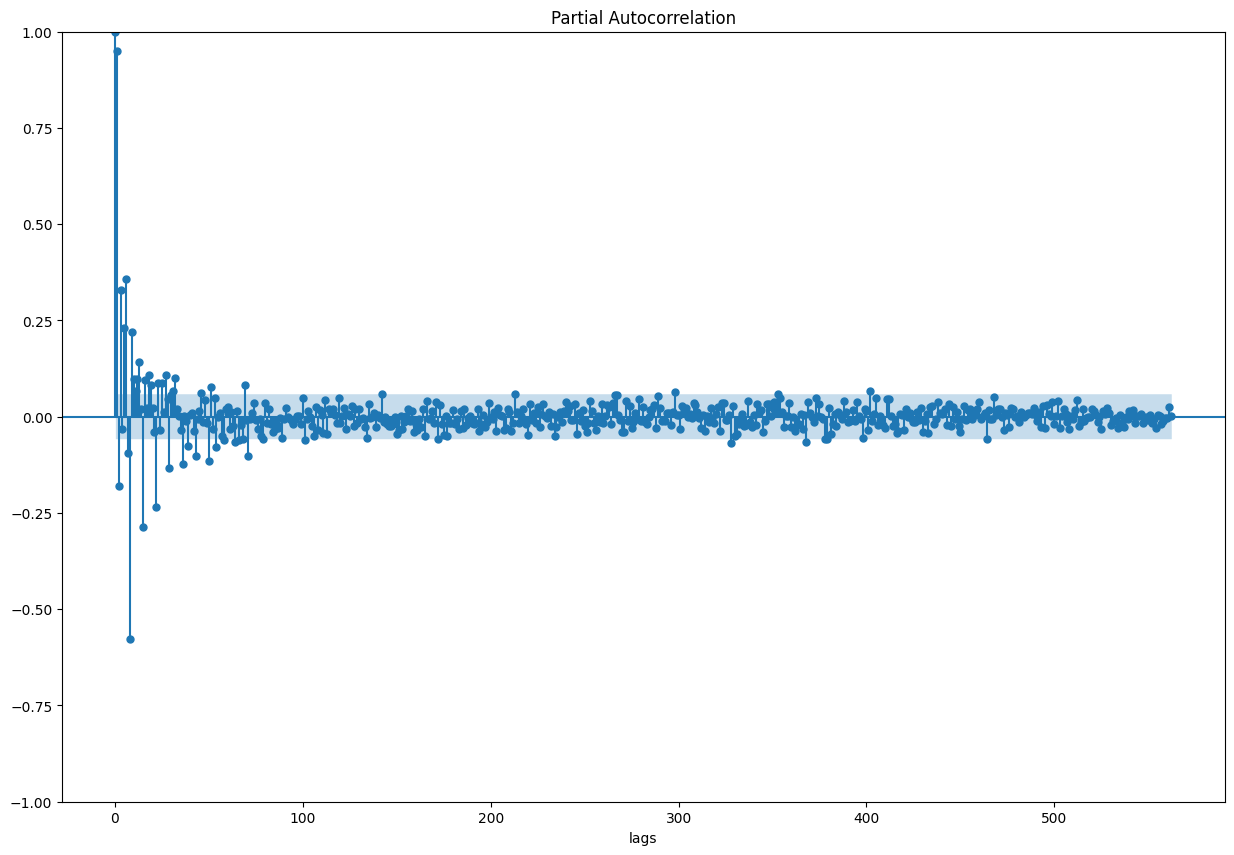

In [ ]:
plot_acf(df_germany.Data, lags=562)
plot_pacf(df_germany.Data, lags=562)
plt.xlabel('lags')
plt.show()

Là je comprends vite fait avec la définition de l'autocorrélation, le nombre de lags c'est l'intervalle entre lesquels tu regardes, on voit la périodicité des données avec les saisons (autocorrélation très forte un an après). Pour la définition de la partial autocorrelation:

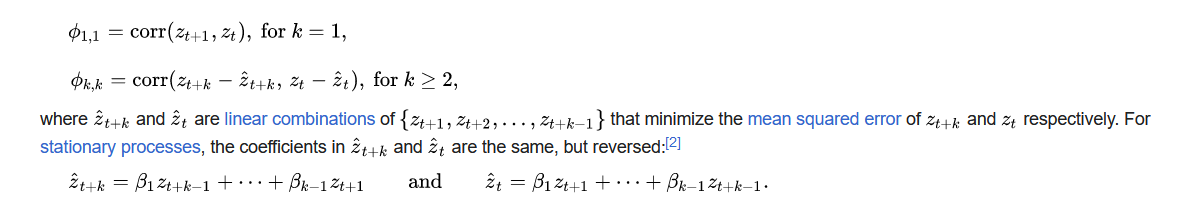

Bon là jsp quoi ils passent en log pour essayer d'avoir un truc stationnaire...

In [ ]:
ts_log = np.log(df_germany['Data'])

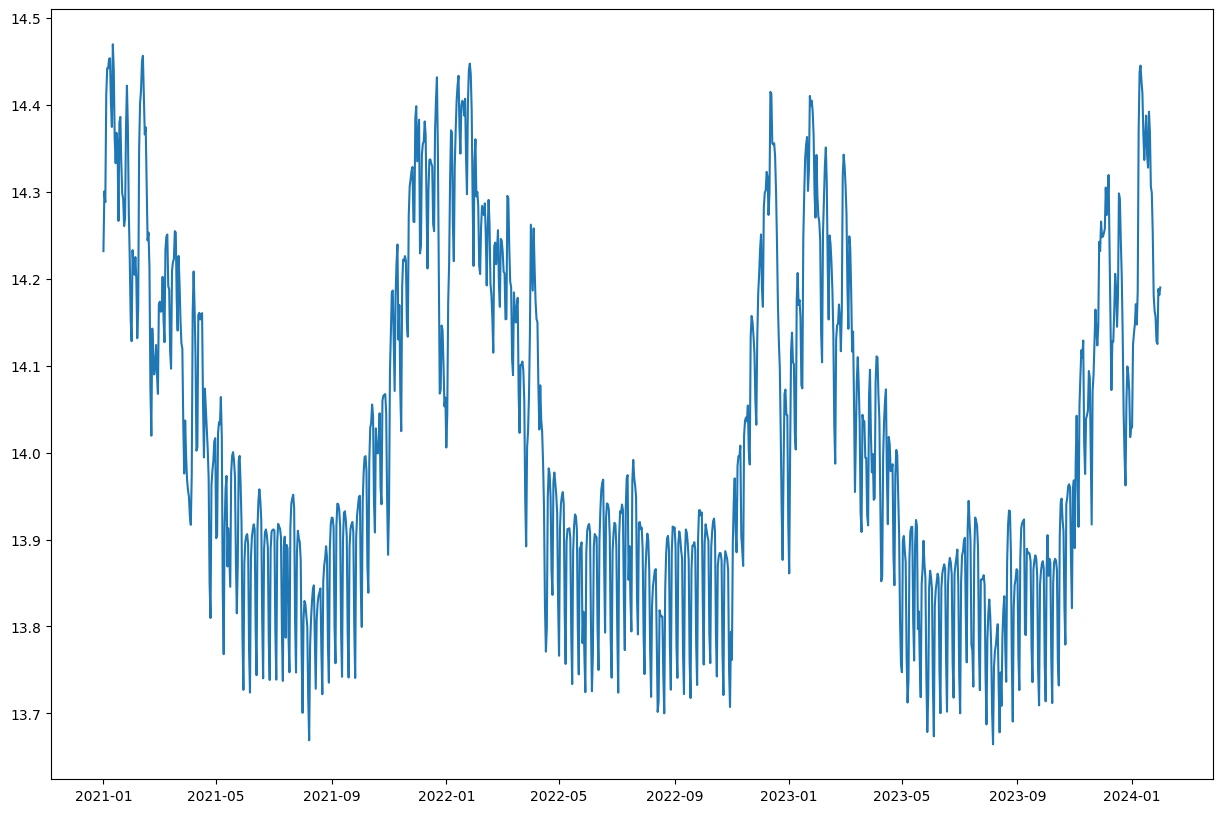

In [ ]:
plt.plot(ts_log)

In [ ]:
ts_log_diff = ts_log - ts_log.shift()
#le .shift() fait juste un shift à droite de 1

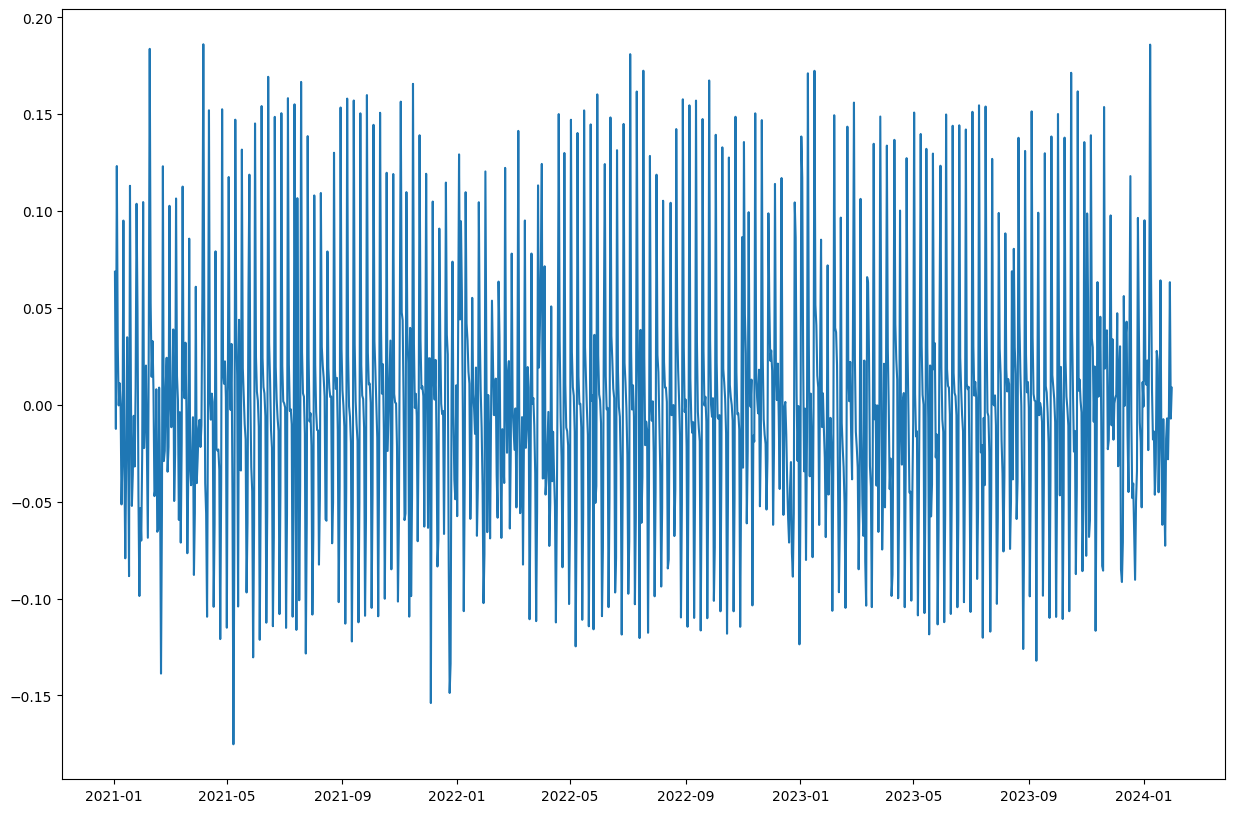

In [ ]:
plt.plot(ts_log_diff)
#on plot la différence avec le suivant


In [ ]:
ts_log_diff.dropna(inplace=True)
#virer les premiers éléments qui sont nan

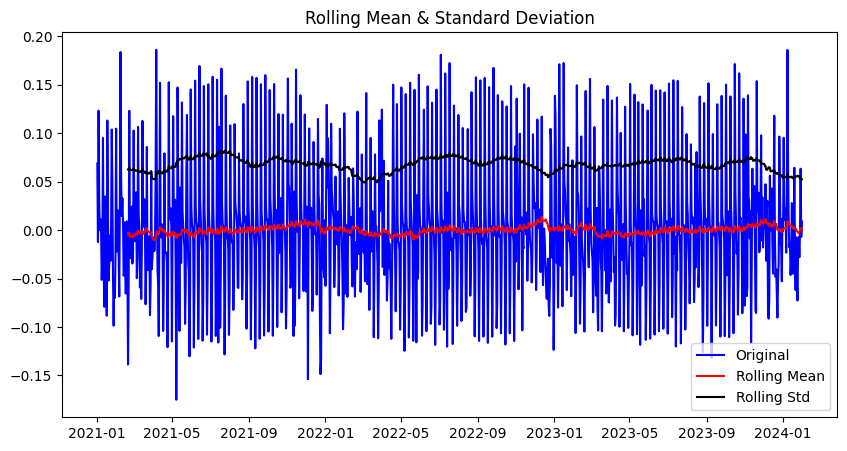

Results of Dickey Fuller Test:


KeyError: 'Data'

In [ ]:
stationarity_check(ts_log_diff)

In [ ]:
p = q = range(1, 4)
print (p)

range(1, 4)


In [ ]:
pq = itertools.product(p, q)
for param in pq:
    try:
        mod = ARMA(ts_log_diff,order=param)
        results = mod.fit()
        print('ARMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

In [ ]:
p = q = range(0, 4)
r = range(0,2)
pqr = itertools.product(p, r, q)
for param in pqr:
    try:
        mod = ARIMA(ts_log_diff,order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{} - MSE:{}'.format(param, results.aic, np.sum(np.square(results.resid))))
    except:
        continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(ts_log_diff,
                                order = (1, 1, 0),
                                seasonal_order= (0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

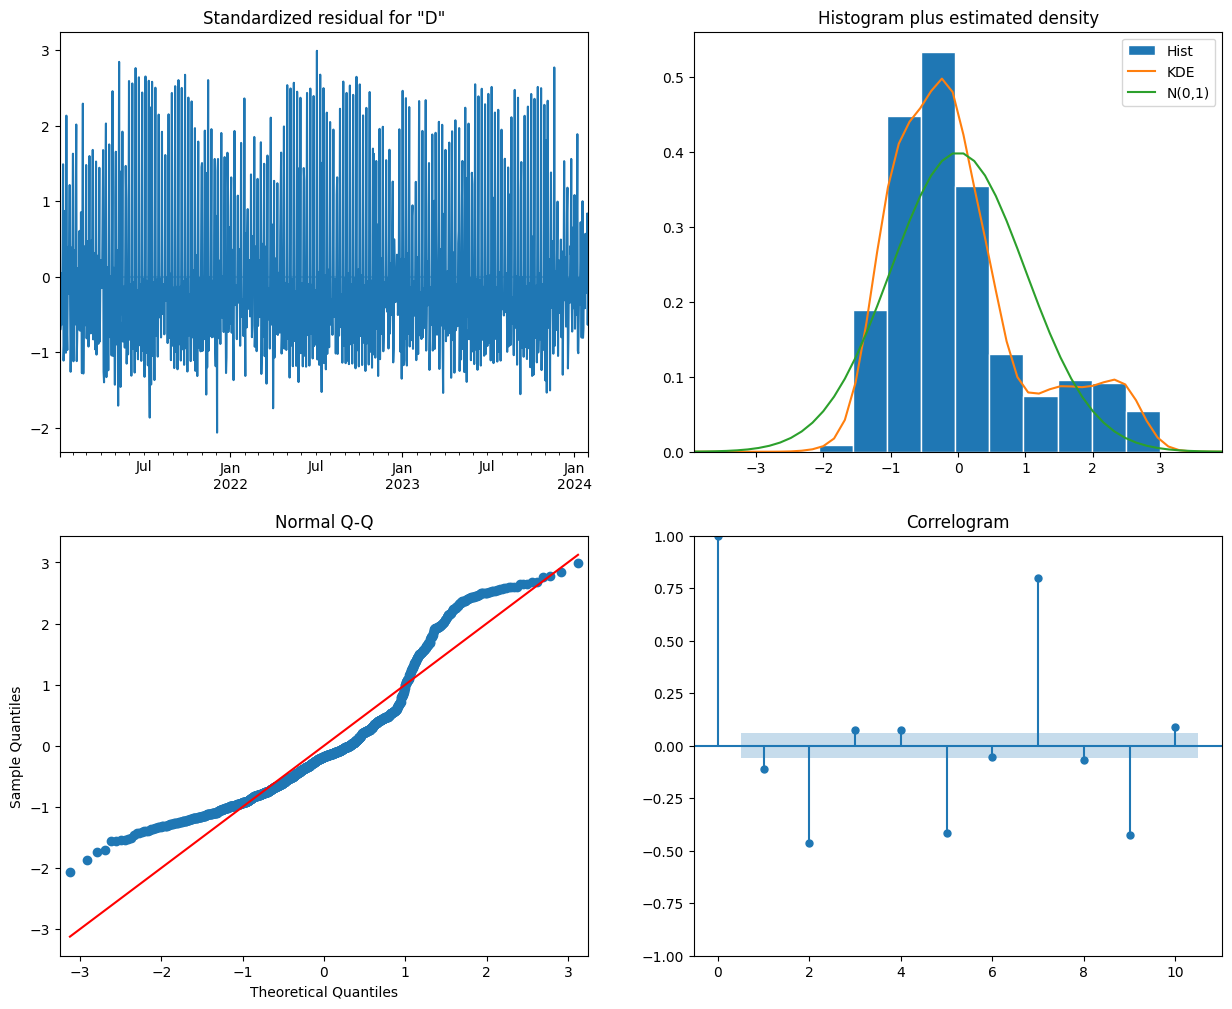

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
residuals = results.resid

In [ ]:
h, pV, Q, cV = lbqtest(residuals, range(1, 20), alpha=0.1)
print ('lag   p-value          Q    c-value   rejectH0')
for i in range(len(h)):
    print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

NameError: name 'lbqtest' is not defined